**CURSO**: Sensores Remotos, Departamento de Geociencias y Medio Ambiente, Universidad Nacional de Colombia - sede Medellín <br/>
**Profesor**: Edier Aristizábal (evaristizabalg@unal.edu.co) <br />
**Credits**: The content of this notebook is taken from several sources such as: [DM Heli](https://medium.com/@shiela.mms/visualising-remotely-sensed-data-from-google-earth-engine-in-python-c12fced85b72). Every effort has been made to trace copyright holders of the materials used in this book. The author apologies for any unintentional omissions and would be pleased to add an acknowledgment in future editions.

# Introducción Earth Engine Python API
Para utilizar el Earth Engine Python API se recomienda instalarlo a travez de Anaconda. Para este ejemplo vamos a crear un ambiente, en el cual instalaremos el API de GEE.

Lo primero es dirigirse a la linea de comandos con la tecla Windows + R, o en start buscar por cmd. De click y se abrirá el command prompt. Si ya tiene instalado Anaconda, utilice el siguiente comando para activar el ambiente

>> Conda activate

Este comando lo dirige al ambiente base. Para crear un ambiente llamado "ee" donde instalará GEE utilice el siguiente comando:

>> conda create --name ee

En realidad puede darle el nombre al ambiente que prefiera. Para activar el ambiente creado utilice:

>> conda activate ee

Ya le debe aparecer el command prompt pero en el ambiente ee. Para instalar el API de GEE en este ambiente utilice el comando:

>> conda install -c conda-forge earthengine-api

Tambíen puede ser instalado *pip*

>>!pip install earthengine-api

Este comando evalua los paquetes que requiere, a lo cual debe decirle que si para terminar con la instalación. Pero antes de estar listo para utlizar el API se deben obtener las credenciales de GEE. Para eso utilice el siguiente comando:

>>earthengine authenticate

Esto lo lleva a una página donde debe seleccionar la cuenta de GEE y autorizar el uso, y obtendrá un código que debe copiar e introducir en el command prompt.

LISTO, ya puede utilizar el API de GEE.

In [ ]:
# Ya estamos listos para importar la libreria ee de GEE
import ee
import ee.mapclient

In [3]:
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

Gtk-Message: 17:19:05.718: Not loading module "atk-bridge": The functionality is provided by GTK natively. Please try to not load it.
[614470, Main Thread] WARNING: GTK+ module /snap/firefox/7355/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process is not supported.: 'glib warning', file /build/firefox/parts/firefox/build/toolkit/xre/nsSigHandlers.cpp:201

(firefox_firefox:614470): Gtk-WARNING **: 17:19:05.780: GTK+ module /snap/firefox/7355/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process is not supported.
Gtk-Message: 17:19:05.780: Failed to load module "canberra-gtk-module"
[614470, Main Thread] WARNING: GTK+ module /snap/firefox/7355/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the s

Enter verification code:  4/1Ab32j91VhwXG_140W7HX1lW_Y18RSTokUhezJnuSxxAbcAluYJst01DJRYM



Successfully saved authorization token.


In [4]:
#If you recieve an error like "AttributeError: module 'collections' has no attribute 'Callable'", please use the following code
import collections
collections.Callable = collections.abc.Callable

In [5]:
# Print the elevation of Mount Everest.
dem = ee.Image('USGS/SRTMGL1_003')
xy = ee.Geometry.Point([86.9250, 27.9881])
elev = dem.sample(xy, 30).first().get('elevation').getInfo()
print('Mount Everest elevation (m):', elev)

Mount Everest elevation (m): 8729


## Map visualization

`ee.Image` objects can be displayed to notebook output cells. The following two
examples demonstrate displaying a static image and an interactive map.

### Static image

The `IPython.display` module contains the `Image` function, which can display
the results of a URL representing an image generated from a call to the Earth
Engine `getThumbUrl` function. The following cell will display a thumbnail
of the SRTM global elevation model.

In [6]:
# Import the Image function from the IPython.display module.
from IPython.display import Image

# Display a thumbnail of global elevation.
Image(url=dem.getThumbUrl({'min': 0, 'max': 3000, 'region':[[[-75.67086291359112,6.072916792136425],
                                      [-75.25475573585675,6.072916792136425],
                                      [-75.25475573585675,6.380084130088567],
                                      [-75.67086291359112,6.380084130088567]]]}))


In this exercise, we’ll render a static map of the land surface temperature of the Philippines in 2021 using the MODIS Terra Land Surface Temperature dataset in Google Earth Engine.

In [8]:
poi = ee.Geometry.Point([122.1247, 13.2735]) # [long, lat]
roi = poi.buffer(distance=9.2e5)

dataset = ee.ImageCollection("MODIS/061/MOD11A1")
dataset = dataset.select('LST_Day_1km')

date_filter = ee.Filter.date('2021-01-01', '2022-01-01')
dataset = dataset.filter(date_filter)

image = dataset.mean()
image = image.multiply(0.02).add(-273.15)
visualisation_params = {
  'min': 8,
  'max': 40,
  'dimensions': 620,
  'region': roi,
  'palette': ['blue', 'yellow', 'red']
}
url = image.getThumbUrl(visualisation_params)

Image(url=url)

Mean land surface temperature of the Philippines in 2021 showing temperature ranges from 8 degrees to 40 degrees Celsius. The bluish spots indicate the cooler temperatures in the mountainous regions; Yellow areas correspond to relatively mild temperate regions; Meanwhile, orange to red areas indicate the hottest regions throughout the year. The reddest area is, as expected, the densest city in the country — Metro Manila.

### Interactive map

The [`folium`](https://python-visualization.github.io/folium/)
library can be used to display `ee.Image` objects on an interactive
[Leaflet](https://leafletjs.com/) map. Folium has no default
method for handling tiles from Earth Engine, so one must be defined
and added to the `folium.Map` module before use.

The following cell provides an example of adding a method for handing Earth Engine
tiles and using it to display an elevation model to a Leaflet map.

In [10]:
# Import the Folium library.
import folium

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, eeImageObject, visParams, name):
  mapID = ee.Image(eeImageObject).getMapId(visParams)
  folium.raster_layers.TileLayer(
    tiles = "https://earthengine.googleapis.com/map/"+mapID['mapid']+
      "/{z}/{x}/{y}?token="+mapID['token'],
    attr = "Map Data &copy; <a href='https://earthengine.google.com/'>Google Earth Engine</a>",
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Set visualization parameters.
visParams = {'min':0, 'max':3000, 'palette':['225ea8','41b6c4','a1dab4','ffffcc']}

# Create a folium map object.
myMap = folium.Map(location=[20, 0], zoom_start=3, height=500)

# Add the elevation model to the map object.
myMap.add_ee_layer(dem, visParams, 'DEM')

# Add a layer control panel to the map.
myMap.add_child(folium.LayerControl())

# Display the map.
display(myMap)

## Chart visualization

Some Earth Engine functions produce tabular data that can be plotted by
data visualization packages such as `matplotlib`. The following example
demonstrates the display of tabular data from Earth Engine as a scatter
plot. See [Charting in Colaboratory](https://colab.sandbox.google.com/notebooks/charts.ipynb)
for more information.

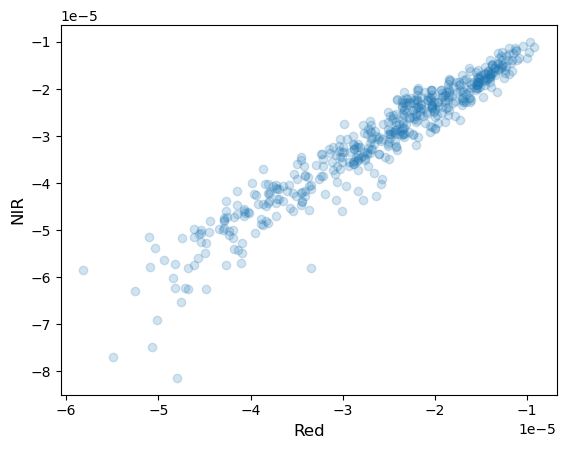

In [14]:
# Import the matplotlib.pyplot module.
import matplotlib.pyplot as plt

# Fetch a Landsat image.
img = ee.Image('LANDSAT/LC08/C02/T1_RT_TOA/LC08_001001_20251013')

# Select Red and NIR bands, scale them, and sample 500 points.
sampFC = img.select(['B3','B4']).divide(10000).sample(scale=30, numPixels=500)

# Arrange the sample as a list of lists.
sampDict = sampFC.reduceColumns(ee.Reducer.toList().repeat(2), ['B3', 'B4'])
sampList = ee.List(sampDict.get('list'))

# Save server-side ee.List as a client-side Python list.
sampData = sampList.getInfo()

# Display a scatter plot of Red-NIR sample pairs using matplotlib.
plt.scatter(sampData[0], sampData[1], alpha=0.2)
plt.xlabel('Red', fontsize=12)
plt.ylabel('NIR', fontsize=12)
plt.show()

In [15]:
# Como ejemplo imprimamos los metadatos del SRTM
print(ee.Image('USGS/SRTMGL1_003').getInfo())

{'type': 'Image', 'bands': [{'id': 'elevation', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': -32768, 'max': 32767}, 'dimensions': [1296001, 417601], 'crs': 'EPSG:4326', 'crs_transform': [0.0002777777777777778, 0, -180.0001388888889, 0, -0.0002777777777777778, 60.00013888888889]}], 'version': 1641990767055141, 'id': 'USGS/SRTMGL1_003', 'properties': {'system:visualization_0_min': '0.0', 'type_name': 'Image', 'keywords': ['dem', 'elevation', 'geophysical', 'nasa', 'srtm', 'topography', 'usgs'], 'thumb': 'https://mw1.google.com/ges/dd/images/SRTM90_V4_thumb.png', 'description': '<p>The Shuttle Radar Topography Mission (SRTM, see <a href="https://onlinelibrary.wiley.com/doi/10.1029/2005RG000183/full">Farr\net al. 2007</a>)\ndigital elevation data is an international research effort that\nobtained digital elevation models on a near-global scale. This\nSRTM V3 product (SRTM Plus) is provided by NASA JPL\nat a resolution of 1 arc-second (approximately 30m).</p><p>This dataset

In [17]:
# Add Earth Engine dataset
# traditional python string
print('Hello world!')

# Earth Eninge object
print(ee.String('Hello World from Earth Engine!').getInfo())
print(ee.Image('LANDSAT/LC08/C02/T1_RT_TOA/LC08_001001_20251013').getInfo())

Hello world!
Hello World from Earth Engine!
{'type': 'Image', 'bands': [{'id': 'B1', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [8761, 8731], 'crs': 'EPSG:32631', 'crs_transform': [30, 0, 373185, 0, -30, 9097215]}, {'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [8761, 8731], 'crs': 'EPSG:32631', 'crs_transform': [30, 0, 373185, 0, -30, 9097215]}, {'id': 'B3', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [8761, 8731], 'crs': 'EPSG:32631', 'crs_transform': [30, 0, 373185, 0, -30, 9097215]}, {'id': 'B4', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [8761, 8731], 'crs': 'EPSG:32631', 'crs_transform': [30, 0, 373185, 0, -30, 9097215]}, {'id': 'B5', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [8761, 8731], 'crs': 'EPSG:32631', 'crs_transform': [30, 0, 373185, 0, -30, 9097215]}, {'id': 'B6', 'data_type': {'type': 'PixelType', 'precision': 'float'

In [28]:
import geemap
geemap.ee_initialize()

Map = geemap.Map(center=[21.79, 70.87], zoom=3)
image = ee.Image('USGS/SRTMGL1_003')
vis_params = {
    'min': 0,
    'max': 6000,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5'],
}
Map.addLayer(image, vis_params, 'SRTM')
Map

Map(center=[21.79, 70.87], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright'…

In [18]:
img=ee.Image('LANDSAT/LC08/C02/T1_RT_TOA/LC08_001001_20251013')

In [20]:
print(img)

ee.Image({
  "functionInvocationValue": {
    "functionName": "Image.load",
    "arguments": {
      "id": {
        "constantValue": "LANDSAT/LC08/C02/T1_RT_TOA/LC08_001001_20251013"
      }
    }
  }
})


In [ ]:
Image(url=img.getThumbURL({'bands':['B4','B3','B2'], 'min':100,'max':3500,
                           'region':[[[-75.67086291359112,6.072916792136425],
                                      [-75.25475573585675,6.072916792136425],
                                      [-75.25475573585675,6.380084130088567],
                                      [-75.67086291359112,6.380084130088567]]]}))

In [ ]:
# Select Red and NIR bands, scale them, and sample 500 points.
samp_fc = img.select(['B3','B4']).divide(10000).sample(scale=30, numPixels=500)

# Arrange the sample as a list of lists.
samp_dict = samp_fc.reduceColumns(ee.Reducer.toList().repeat(2), ['B3', 'B4'])
samp_list = ee.List(samp_dict.get('list'))

# Save server-side ee.List as a client-side Python list.
samp_data = samp_list.getInfo()

# Display a scatter plot of Red-NIR sample pairs using matplotlib.
plt.scatter(samp_data[0], samp_data[1], alpha=0.8)
plt.xlabel('Red', fontsize=12)
plt.ylabel('NIR', fontsize=12)
plt.show()

In [ ]:
Map = emap.Map(center=[40,-100], zoom=4)
Map.add_basemap('ROADMAP') # Add Google Map
Map


# Add Earth Engine dataset
# Get a download URL for an image.
image1 = ee.Image('srtm90_v4')
path = image1.getDownloadUrl({
    'scale': 30,
    'crs': 'EPSG:4326',
    'region': '[[-75.81280448742132,5.696650254732558], [-74.86248710460882,5.696650254732558], [-74.86248710460882,6.605986306802248], [-75.81280448742132,6.605986306802248]]'
})

print(path)
vis_params = {'min': 0, 'max': 3000}
Map.addLayer(image1, vis_params)

Map.addLayerControl()
Map

NameError: name 'emap' is not defined

In [ ]:
#el mapa base...
Map = emap.Map(center=[40,-100], zoom=4)
Map.add_basemap('RELIEF')
Map

Para importar y filtrar una imagen

In [ ]:


# Load a Landsat 8 collection.
collection = ee.ImageCollection('LANDSAT/LC08/C01/T1') \
    .filterBounds(ee.Geometry.Point(-75.4, 6.4)) \
    .filterDate('2019-01-01', '2019-12-31') \
    .sort('CLOUD_COVER')

# Compute the median of each pixel for each band of the 5 least cloudy scenes.
median = collection.limit(5).reduce(ee.Reducer.median())

# Define visualization parameters in an object literal.
vizParams = {'bands': ['B4_median', 'B3_median', 'B2_median'],
             'min': 5000, 'max': 15000, 'gamma': 1.3}

Map.setCenter(-75.4, 6.4, 9)
Map.addLayer(median, vizParams, 'Median image')

#Para que aparezca el mapa
Map.addLayerControl()
Map

AttributeError: 'Map' object has no attribute 'setCenter'

Para importar features desde las bases de datos

In [ ]:
Map = emap.Map(center=[40,-100], zoom=4)
Map.add_basemap('ROADMAP')
Map

# Load a feature collection.
featureCollection = ee.FeatureCollection('TIGER/2016/States')

# Filter
filteredFC = featureCollection.filter(ee.Filter.eq('NAME', 'California'))

Map.addLayer(ee.Image().paint(filteredFC, 0, 2),
             {'palette': 'red'}, 'California')

Map.addLayerControl()
Map

Para cargar un feature desde el Assets de GEE

In [ ]:
Map = emap.Map(center=[40,-100], zoom=4)
Map.add_basemap('ROADMAP')
Map

antioquia = ee.FeatureCollection('users/evaristizabalg/Antioquia')

Map.center_object(antioquia,7)
Map.addLayer(antioquia, {}, 'Antioquia')

Map.addLayerControl()
Map

In [ ]:
Map = emap.Map(center=[40,-100], zoom=4)
Map.add_basemap('ROADMAP')
Map

AMVA = ee.FeatureCollection("G:\My Drive\INVESTIGACION\Cartografia/AMVA");

Map.center_object(AMVA,7)
Map.addLayer(AMVA, {}, 'AMVA')

Map.addLayerControl()
Map


In [ ]:
# Installs geemap package
import subprocess

try:
    import geemap
except ImportError:
    print('geemap package not installed. Installing ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])

# Checks whether this notebook is running on Google Colab
try:
    import google.colab
    import geemap.eefolium as emap
except:
    import geemap as emap

geemap package not installed. Installing ...


In [ ]:
Map = emap.Map(center=[40,-100], zoom=4)
Map.add_basemap('ROADMAP')
Map

Tiempo1 = ee.ImageCollection ('COPERNICUS/S2') \
  .filterDate ('2017-01-01' ,'2018-01-01') \
  .sort('CLOUD_COVER')
Tiempo1b = Tiempo1.reduce(ee.Reducer.min())

Tiempo2 = ee.ImageCollection ('COPERNICUS/S2') \
  .filterDate ('2018-01-01' ,'2019-01-01') \
  .sort('CLOUD_COVER');
Tiempo2b = Tiempo2.reduce(ee.Reducer.min())

NDVI1 = Tiempo1b.normalizedDifference (['B8_min', 'B4_min'])
NDVI2 = Tiempo2b.normalizedDifference (['B8_min', 'B4_min'])

# Compute the difference in NDVI.
ndviDifference = NDVI2.subtract(NDVI1)

antioquia = ee.FeatureCollection('users/evaristizabalg/Antioquia')

# Update the NDVI difference mask with the land mask.
maskedDifference = ndviDifference.clip(antioquia)

# Display the masked result.
vizParams = {'min': -0.5, 'max': 0.5,
             'palette': ['FF0000', 'FFFFFF', '0000FF']}
Map.center_object(antioquia,7)
Map.addLayer(maskedDifference, vizParams, 'NDVI difference')

Map.addLayerControl()
Map

In [ ]:
Map = emap.Map(center=[40,-100], zoom=4)
Map.add_basemap('ROADMAP') # Add Google Map
Map

# This function gets NDVI from Landsat<8 imagery.
def getNDVI(image):
    return image.normalizedDifference(['B4', 'B3'])

image = ee.Image('LANDSAT/LC08/C01/T1_RT/LC08_009056_20190903')

# Compute NDVI from the scenes.
ndvi = getNDVI(image)

ndviParams = {'min':-0.2, 'max':0.2,'palette': ['#d73027', '#f46d43', '#fdae61',
                          '#fee08b', '#d9ef8b', '#a6d96a', '#66bd63', '#1a9850']}
Map.addLayer(ndvi, ndviParams, 'NDVI')
Map.centerObject(image, 10)

# This function gets NDVI from Landsat 8 imagery.
def addNDVI(image):
    return image.addBands(image.normalizedDifference(['B5', 'B4']))

# filtrar
collection = ee.ImageCollection('LANDSAT/LC08/C01/T1') \
    .filterBounds(ee.Geometry.Point(-75.4, 6.4)) \
    .filterDate('2014-01-01', '2014-12-31')

# aplicar a toda la colecction (Map)
ndviCollection = collection.map(addNDVI)

first = ndviCollection.first()
print(first.getInfo())

bandNames = first.bandNames()
print(bandNames.getInfo())

Map.addLayerControl()
Map

## Sentinel 2

In [ ]:
image = ee.ImageCollection('COPERNICUS/S2') \
  .filterDate('2017-01-01', '2017-01-02').median() \
  .divide(10000) \
  .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B12'])

EEException: Earth Engine client library not initialized. Run `ee.Initialize()`

In [ ]:
vis = {'bands': ['B4', 'B3', 'B2'], 'min': 0.05, 'max': 0.5}

In [ ]:
# TEST: add feature to the Map
ee.mapclient.addToMap(image, vis,'S2')

otros

In [ ]:
area = ee.Geometry.Polygon([[[-75.69327597674794,6.097637610738173],[-75.41861777362294,6.097637610738173],[-75.41861777362294,6.318123436693424],[-75.69327597674794,6.318123436693424],[-75.69327597674794,6.097637610738173]]])

In [ ]:
# define the image
img = ee.Image("COPERNICUS/S2/20190827T152649_20190827T152643_T18NVM")

In [ ]:
# do any ee operation here
ndvi = ee.Image(img.normalizedDifference(['B8', 'B4']))

In [ ]:
timedate = img.get('GENERATION_TIME').getInfo()

In [ ]:
# get the lat lon and add the ndvi
latlon = ee.Image.pixelLonLat().addBands(ndvi)

In [ ]:
# apply reducer to list
latlon = latlon.reduceRegion(
  reducer=ee.Reducer.toList(),
  geometry=area,
  maxPixels=1e8,
  scale=20);

In [ ]:
# get data into three different arrays
data = np.array((ee.Array(latlon.get("nd")).getInfo()))
lats = np.array((ee.Array(latlon.get("latitude")).getInfo()))
lons = np.array((ee.Array(latlon.get("longitude")).getInfo()))

In [ ]:
# get the unique coordinates
uniqueLats = np.unique(lats)
uniqueLons = np.unique(lons)

In [ ]:
# get number of columns and rows from coordinates
ncols = len(uniqueLons)
nrows = len(uniqueLats)


In [ ]:
# determine pixelsizes
ys = uniqueLats[1] - uniqueLats[0]
xs = uniqueLons[1] - uniqueLons[0]


In [ ]:
# create an array with dimensions of image
arr = np.zeros([nrows, ncols], np.float32) #-9999

In [ ]:
# fill the array with values
counter =0
for y in range(0,len(arr),1):
    for x in range(0,len(arr[0]),1):
        if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
            counter+=1
            arr[len(uniqueLats)-1-y,x] = data[counter] # we start from lower left corner

In [ ]:
# in case you want to plot the image
import matplotlib.pyplot as plt
plt.imshow(arr)
plt.show()

In [ ]:
# set the
#SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
transform = (np.min(uniqueLons),xs,0,np.max(uniqueLats),0,-ys)

In [ ]:
# set the coordinate system
target = osr.SpatialReference()
target.ImportFromEPSG(4326)

In [ ]:
# set driver
driver = gdal.GetDriverByName('GTiff')


In [ ]:
timestring = time.strftime("%Y%m%d_%H%M%S")
outputDataset = driver.Create("G:\My Drive\ANALISIS GEOESPACIAL\Talleres en Python/output.tif", ncols,nrows, 1,gdal.GDT_Float32)


In [ ]:
# add some metadata
outputDataset.SetMetadata( {'time': str(timedate), 'someotherInfo': 'lala'} )

In [ ]:
outputDataset.SetGeoTransform(transform)
outputDataset.SetProjection(target.ExportToWkt())
outputDataset.GetRasterBand(1).WriteArray(arr)
outputDataset.GetRasterBand(1).SetNoDataValue(-9999)
outputDataset = None

In [ ]:
# Define the roi
area = ee.Geometry.Polygon([[-75.69327597674794,6.197637610738173],\
                            [-75.51861777362294,6.197637610738173],\
                            [-75.51861777362294,6.318123436693424],\
                            [-75.69327597674794,6.318123436693424],\
                            [-75.69327597674794,6.197637610738173]])

In [ ]:
# define the image
collection = ee.ImageCollection("COPERNICUS/S2").filterBounds(area)\
                                      .filterDate("2018-01-01","2019-01-10")\
                                      .filterMetadata("CLOUDY_PIXEL_PERCENTAGE","less_than",10)\
                                      .select(['B8', 'B4'])

print(" number of images: ",collection.size().getInfo())

In [ ]:
# perform any calculation on the image collection here
def anyFunction(img):
    ndvi = ee.Image(img.normalizedDifference(['B8', 'B4'])).rename(["ndvi"])
    return ndvi

In [ ]:
# export the latitude, longitude and array
def LatLonImg(img):
    img = img.addBands(ee.Image.pixelLonLat())

    img = img.reduceRegion(reducer=ee.Reducer.toList(),\
                                        geometry=area,\
                                        maxPixels=1e13,\
                                        scale=10);

    data = np.array((ee.Array(img.get("result")).getInfo()))
    lats = np.array((ee.Array(img.get("latitude")).getInfo()))
    lons = np.array((ee.Array(img.get("longitude")).getInfo()))
    return lats, lons, data

In [ ]:
# covert the lat, lon and array into an image
def toImage(lats,lons,data):

    # get the unique coordinates
    uniqueLats = np.unique(lats)
    uniqueLons = np.unique(lons)

    # get number of columns and rows from coordinates
    ncols = len(uniqueLons)
    nrows = len(uniqueLats)

    # determine pixelsizes
    ys = uniqueLats[1] - uniqueLats[0]
    xs = uniqueLons[1] - uniqueLons[0]

    # create an array with dimensions of image
    arr = np.zeros([nrows, ncols], np.float32) #-9999

    # fill the array with values
    counter =0
    for y in range(0,len(arr),1):
        for x in range(0,len(arr[0]),1):
            if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                counter+=1
                arr[len(uniqueLats)-1-y,x] = data[counter] # we start from lower left corner
    return arr

In [ ]:

# map over the image collection
myCollection  = collection.map(anyFunction)

# get the median
result = ee.Image(myCollection.median()).rename(['result'])

# get the lon, lat and result as 1d array
lat, lon, data = LatLonImg(result)

# 1d to 2d array
image  = toImage(lat,lon,data)

# in case you want to plot the image
import matplotlib.pyplot as plt
plt.imshow(image)
plt.show()